# Kelvin-Helmoltz instability

The Kelvin–Helmholtz instability (after Lord Kelvin and Hermann von Helmholtz) can occur when there is velocity shear in a single continuous fluid, or where there is a velocity difference across the interface between two fluids. An example is wind blowing over water: The instability manifests in waves on the water surface. More generally, clouds, the ocean, Saturn's bands, Jupiter's Red Spot, and the sun's corona show this instability.

In [1]:
import numpy as np
import sympy as sp
import pyLBM

%matplotlib notebook

In [24]:
X, Y = sp.symbols('X, Y')
rho, qx, qy, LA = sp.symbols('rho, qx, qy, LA', real=True)

def bc_up(f, m, x, y, driven_velocity):
    m[qx] = driven_velocity

def vorticity(sol):
    qx_n = sol.m[qx]
    qy_n = sol.m[qy]
    vort = np.abs(qx_n[1:-1, 2:] - qx_n[1:-1, :-2]
                  - qy_n[2:, 1:-1] + qy_n[:-2, 1:-1])
    return vort.T

def qx0(x, y, U, k):
    return np.zeros_like(x) + U*np.tanh(k*(y-.25))*(y<=.5) + U*np.tanh(k*(.75 - y))*(y>.5)

def qy0(x, y, U, delta):
    return np.zeros_like(y) + U*delta*np.sin(2*np.pi*(x + .25)) 

def feq(v, u):
    c0 = LA/sp.sqrt(3)
    x, y = sp.symbols('x, y')
    vsymb = sp.Matrix([x, y])
    w = sp.Matrix([sp.Rational(4,9)] + [sp.Rational(1, 9)]*4 + [sp.Rational(1, 36)]*4)
    f = rho*(1 + u.dot(vsymb)/c0**2 + u.dot(vsymb)**2/(2*c0**4) - u.norm()**2/(2*c0**2))
    return sp.Matrix([w[iv]*f.subs([(x, vv[0]*LA), (y, vv[1]*LA)]) for iv, vv in enumerate(v)])

dx = 1./128
Tf = 0.6

rhoo = 1.
U = .5
k = 80
delta = .05

#Ma = .04
#mu = .0366
#nu = 1e-4

Ma = 0.1
mu = .0366
nu = 1e-4
lamb = np.sqrt(3)/Ma

sigma3 = 3*mu/(rhoo*lamb*dx)
sigma4 = 3*nu/(rhoo*lamb*dx)
s3 = 1./(sigma3+.5)
s4 = 1./(sigma4+.5)
s  = [0.,0.,0.,s3,s4,s4,s3,s3,s3]

kelvin_helmoltz = {
    'parameters': {LA: lamb},
    'box': {
        'x': [0., 1.], 
        'y': [0., 1.], 
        'label': -1,
    },
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes': [
        {
            'velocities': list(range(9)),
            'polynomials': [
                1, X, Y,
                X**2 + Y**2,
                X**2 - Y**2,
                X*Y,
                X*(X**2+Y**2),
                Y*(X**2+Y**2),
                (X**2+Y**2)**2                    
            ],
            'relaxation_parameters': s,
            'feq': (feq, (sp.Matrix([qx/rho, qy/rho]),)),
            'conserved_moments': [rho, qx, qy],
            'init': {
                rho: 1., 
                qx: (qx0, (U, k)), 
                qy: (qy0, (U, delta)),
            },
        },
    ],
    'generator': 'cython',
}


sol = pyLBM.Simulation(kelvin_helmoltz)

<IPython.core.display.Javascript object>


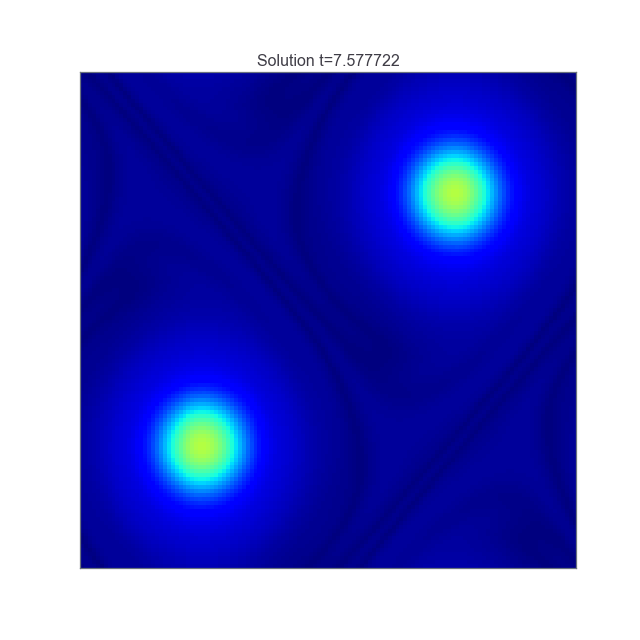

In [25]:
def update(iframe):
    nrep = 32
    for i in range(nrep):
        sol.one_time_step()
    image.set_data(vorticity(sol))
    ax.title = "Solution t={0:f}".format(sol.t)

# init viewer
viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(figsize=(8,8))
ax = fig[0]
ax.grid(visible = False)
ax.xaxis_set_visible(False)
ax.yaxis_set_visible(False)
image = ax.image(vorticity, (sol,), cmap='jet')
    
# run the simulation
fig.animate(update, interval=1)
fig.show()